<h1 style="font-size:30px;">Transfer Learning using VGG-16 (Fine Tuning Pre-Trained Layers)</h1>  

In the previous notebook, we demonstrated that we could use **transfer learning** to create a new classifier for the ASL dataset. However, we showed that freezing the entire convolutional base with pre-trained weights from ImageNet training did not result in a highly effective classifier. This is due to the fact that the ImageNet weights do not capture some of the unique features that are required for ASL dataset. In this notebook, we are going to introduce a hybrid approach to transfer learning where we use pre-trained weights for the first several layers of the network (that have learned more general features from ImageNet) and then allow the model to tune the weights for the subsequent convolutional blocks (plus the fully connected layers). This approach is called **fine-tuning** because it makes small adjustments to the more abstract representations of the model being reused to make them more relevant for the problem at hand.

**The transfer learning and fine-tuning process is summarized below:**

1. Instantiate the VGG-16 convolutional base with pre-trained weights from ImageNet
2. Configure the convolutional base as "trainable"
3. Freeze all the layers in the convolutional base (EXCEPT the last four)
4. Add a dense classifier layer for the ASL dataset
5. Train the model (the last four layers of the convolutional base plus the dense classifier)

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_cnn_vgg_pretrained_small_base_ASL.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Fine-Tuning using the VGG-16 Model](#4-Fine-Tuning-using-the-VGG-16-Model)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

## 1 System Configuration

In [ ]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Download and Extract the Dataset

In [ ]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    'https://www.dropbox.com/s/7huaqeavdbz32la/dataset_ASL_150.zip?dl=1', 
    'dataset_ASL_150.zip'
)
    
unzip(zip_file='dataset_ASL_150.zip')

Extracted all


## 3 Dataset and Training Configuration

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    DATA_ROOT:   str = './dataset_ASL_150'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0001
    CHECKPOINT_DIR: str   = './saved_models_asl'

## 4 Modeling VGG-16

The Keras API provides the following utility that is used to instantiate a VGG-16 model, which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset** as a starting point for **Fine-Tuning.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

### 4.1 How to Fine-Tune a Pre-Trained Model?
The general approach to **fine-tuning** a convolutional base is to first load the pre-trained weights for the model and then selectively allow the last few convolutional layers in the base to be **trainable**. The process of selectively specifying which layers are trainable and which ones are not is often referred to as freezing or un-freezing layers via the model's **`trainable`**  attribute. In the figure below, we show the convolutional base has been loaded with pre-trained weights from ImageNet. We then "freeze" the first portion of the convolutional base to preserve the features learned from ImageNet, but we allow the last four layers to be fine-tuned during the training process. We use the term "fine-tuning" in this context because we expect the last few layers of the convolutional base (pre-trained on ImageNet) to contain feature representations that are "pretty good", but require further refinement to be more relevant for the ASL dataset.

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_cnn_vgg_pretrained_fine_tune.png' width=700 align='center'><br/>

Ideally, you should train the dense layers first (keeping the entire convolutional base frozen) as we did in the case of the "transfer learning with feature extraction experiment" and then start tuning the convolutional layers at a lower learning rate. However, in order to keep things simple in this example, we will train the model just once, which will include the last few layers of the convolutional base as well as the dense classifier. 

In practice, when fine-tuning a model, it is better to start with fine-tuning just a few layers at a time to see how the model responds. As we will see in this example, tuning both the convolutional base and the dense layers at a lower learning rate works without any issues. However, if you are training the full convolutional base for fine-tuning, you should try to train the dense layers first and then start fine-tuning. 

### 4.2 VGG Convolutional Base
We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. In this notebook, we will instantiate the model with weights that were learned by training the model on the ImageNet dataset.

#### How to freeze only a few layers?
There are two ways to specify which layers in the model are trainable (tunable). 
1. We can start by making the entire convolutional base trainable by setting the `trainable` flag to `True`. Then loop over the **initial** layers and make them untrainable by setting the same (`trainable`) flag for each layer to `False`. 

2. We can freeze the entire convolutional base by setting the `trainable` flag to `False`, and then loop over the  **last** few layers and set the `trainable` flag to `True`.

We use the first approach in this notebook. In the code cell below, we start by setting the entire convolutional base as "trainable" by settng the `trainable` attribute to `True`.

In [ ]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
# First make the convolutional base trainable.
vgg16_conv_base.trainable = True
print('All weights trainable, fine tuning...')

Loading model with ImageNet weights...
58900480/58889256 [==============================] - 1s 0us/step
All weights trainable, fine tuning...


In [ ]:
print(vgg16_conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.3 Unfreeze the Last Four Layers for Fine-Tuning

In the previous section, we set the `trainable` attribute of the convolutional base to `True`. This now allows us to "freeze" a selected number of layers in the convolutional base so that only the last few layers in the convolutional base are trainable. 

In [ ]:
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = 4
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
    
print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x7f8f1b369f90>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f0ac30950>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f023e6950>
FREEZING LAYER: <keras.layers.pooling.MaxPooling2D object at 0x7f8f17235090>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f0245e510>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f024582d0>
FREEZING LAYER: <keras.layers.pooling.MaxPooling2D object at 0x7f8f02464e50>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f0246c990>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f0246cad0>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f02458190>
FREEZING LAYER: <keras.layers.pooling.MaxPooling2D object at 0x7f8f02403290>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f026c0e10>
FREEZING LAYER: <keras.layers.convolutional.Conv2D object at 0x7f8f0240855

### 4.4 Add the Classification Layer
Since we intend to train and use the model to classify hand signals from the ASL dataset (which has 29 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 29 nodes for each of the 29 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset. This is the same approach we used in the previous notebook.

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
    
x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
    
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
    
# The final model.
vgg16_model = keras.Model(inputs, outputs)

print(vgg16_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                             

### 4.5 Prepare the Training and Validation Dataset

In [ ]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='training',
                                             validation_split=0.2
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='validation',
                                             validation_split=0.2
                                            )

Found 4350 files belonging to 29 classes.
Using 3480 files for training.
Found 4350 files belonging to 29 classes.
Using 870 files for validation.


### 4.6 Display Sample Images

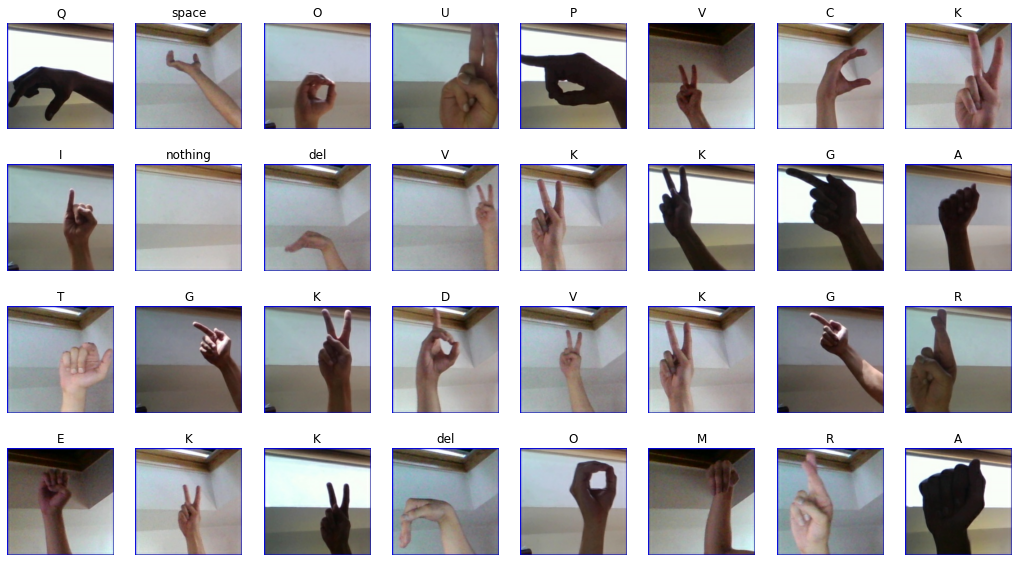

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.7 Compile and Train the Model

In [ ]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [ ]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [ ]:
print(f"Model evaluation accuracy: {vgg16_model.evaluate(valid_dataset)[1]*100.:.3f}")

28/28 [==============================] - 11s 95ms/step - loss: 18.0234 - accuracy: 0.0322
Model evaluation accuracy: 3.218


In [ ]:
# Train the Model.
training_results = vgg16_model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
109/109 [==============================] - 18s 151ms/step - loss: 2.6408 - accuracy: 0.3514 - val_loss: 0.9602 - val_accuracy: 0.7115
Epoch 2/51
109/109 [==============================] - 16s 143ms/step - loss: 0.4799 - accuracy: 0.8537 - val_loss: 0.3856 - val_accuracy: 0.8966
Epoch 3/51
109/109 [==============================] - 16s 146ms/step - loss: 0.1127 - accuracy: 0.9644 - val_loss: 0.2646 - val_accuracy: 0.9368
Epoch 4/51
109/109 [==============================] - 16s 143ms/step - loss: 0.0630 - accuracy: 0.9819 - val_loss: 0.2384 - val_accuracy: 0.9494
Epoch 5/51
109/109 [==============================] - 16s 147ms/step - loss: 0.0568 - accuracy: 0.9856 - val_loss: 0.1516 - val_accuracy: 0.9540
Epoch 6/51
109/109 [==============================] - 13s 121ms/step - loss: 0.0452 - accuracy: 0.9925 - val_loss: 0.2038 - val_accuracy: 0.9529
Epoch 7/51
109/109 [==============================] - 13s 121ms/step - loss: 0.0355 - accuracy: 0.9897 - val_loss: 0.2718 - val_ac

### 4.8 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

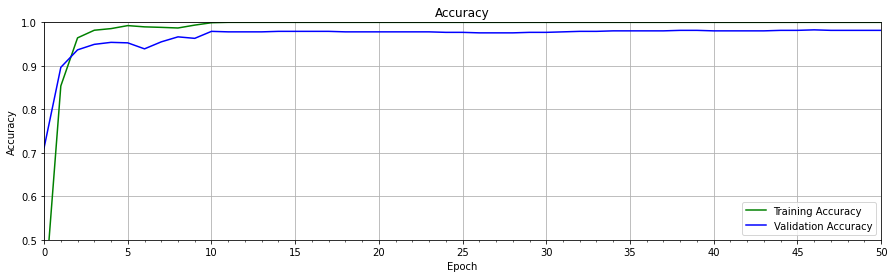

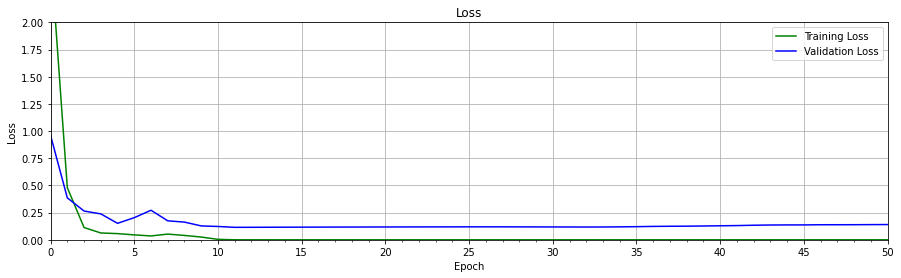

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 5 Model Evaluation

In [ ]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

28/28 [==============================] - 3s 86ms/step - loss: 0.1385 - accuracy: 0.9828
Model evaluation accuracy: 98.276


In [ ]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return  

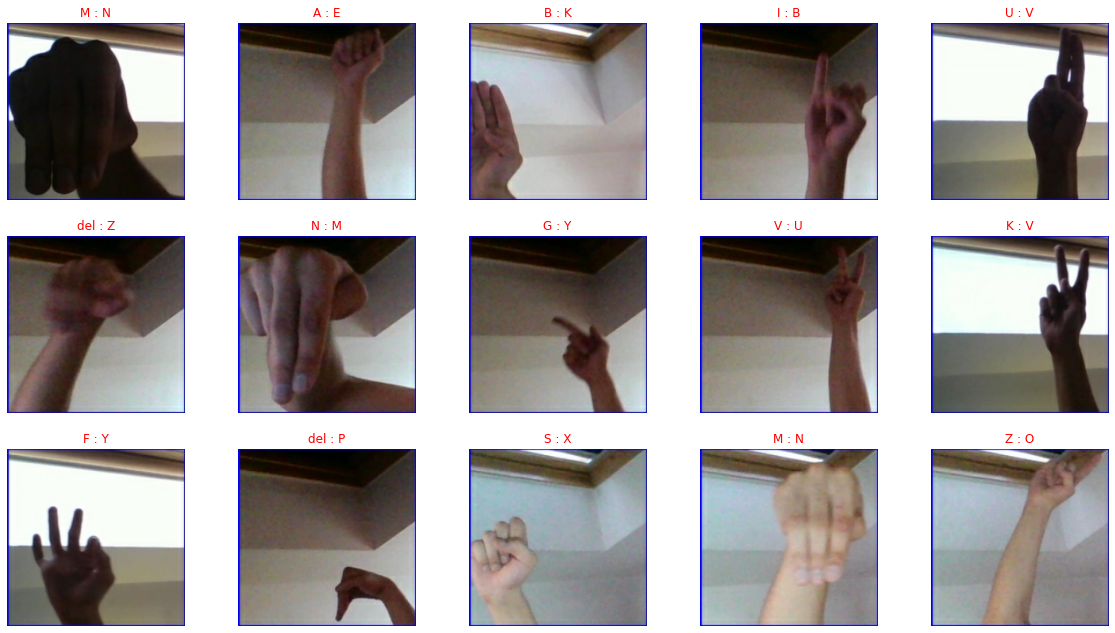

In [ ]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we showed how you can use **fine-tuning** to make adjustments to the weights in the last few layers of a pre-trained convolutional base to improve the validation accuracy of the model. This is a very common technique that is used to leverage pre-existing models for new datasets. When using this approach, it is recommended that you first train the dense classifier only and then un-freeze the layers in the convolutional base that you wish to fine-tune and the model again (including the dense classifier) at a lower learning rate. 